# Bechmark Solutions of PDE System for Biological Network Formulation

Second order FDM with Staggerd Grid, Second order BDF

In [1]:
%matplotlib inline
import numpy as np
from scipy import linalg
from math import pi
from matplotlib import pyplot
from matplotlib import rcParams, cm
from mpl_toolkits.mplot3d import Axes3D
from scipy.fftpack import fft, dct
#rcParams['font.family'] = 'serif'
#rcParams['font.size'] = 16

In [2]:
import numba
from numba import jit

In [3]:
print(numba.__version__)

0.35.0+6.gaa35fb1


In [4]:
from laplace_helper import plot_3D, L2_rel_error
from cg_helper import poisson_2d, p_analytical

In [5]:
def idct_2d(a):
    return dct(dct(a, type=3, axis=1, norm='ortho'), type=3, axis = 0, norm='ortho')

In [6]:
def dct_2d(a):
    return dct(dct(a, type=2, axis=1, norm='ortho'), type=2, axis = 0, norm='ortho')

In [7]:
def preconditioner(s, dx, dy):
    ny, nx = s.shape
    lambda_ = np.zeros((ny,nx))
    lambda_[0,0] = 1
    lambda_[1:,0] = 4*np.sin(0.5*np.arange(1,ny)*np.pi/ny)**2/dy**2
    lambda_[0,1:] = 4*np.sin(0.5*np.arange(1,nx)*np.pi/nx)**2/dx**2
    lambda_[1:,1:] = 4*((np.sin(0.5*np.arange(1,ny)*np.pi/ny)**2/dy**2)[:,None] 
                        + (np.sin(0.5*np.arange(1,nx)*np.pi/nx)**2/dx**2)[None,:])
    s_hat = dct_2d(s)
    s_hat[0,0] = 0
    return idct_2d(s_hat/lambda_)

We will again update $\bf p$ according to 

\begin{equation}
{\bf p}^{k+1}={\bf p}^k + \alpha {\bf d}^k
\end{equation}

but use the modified equations above to calculate $\alpha$ and ${\bf d}^k$.  

You may have noticed that $\beta$ depends on both ${\bf r}^{k+1}$ and ${\bf r}^k$ and that makes the calculation of ${\bf d}^0$ a little bit tricky.  Or impossible (using the formula above).  Instead we set ${\bf d}^0 = {\bf r}^0$ for the first step and then switch for all subsequent iterations.  

Thus, the full set of steps for the method of conjugate gradients is:

Calculate ${\bf d}^0 = {\bf r}^0$ (just  once), then

1. Calculate $\alpha = \frac{{\bf r}^k \cdot {\bf r}^k}{A{\bf d}^k \cdot {\bf d}^k}$
2. Update ${\bf p}^{k+1}$
3. Calculate ${\bf r}^{k+1} = {\bf r}^k - \alpha A {\bf d}^k$ $\ \ \ \ $(see <a href='#references'>Shewchuk (1994)</a>)
4. Calculate $\beta = \frac{{\bf r}^{k+1} \cdot {\bf r}^{k+1}}{{\bf r}^k \cdot {\bf r}^k}$
5. Calculate ${\bf d}^{k+1}={\bf r}^{k+1}+\beta{\bf d}^{k}$
6. Repeat!

In [8]:
def pcg_elliptic(p, mx, my, r, elliptic, s, dx, dy, dt, l2_target):
    '''Performs cg relaxation
    Assumes Dirichlet boundary conditions p=0
    
    Parameters:
    ----------
    p: 2D array of floats
       Initial guess
    b: 2D array of floats
       Source term
    A: a function with 2D array of floats as input
       elliptic operator
    dx: float
        Mesh spacing in x direction
    dy: float
        Mesh spacing in y direction
    l2_target: float
        exit criterion
        
    Returns:
    -------
    p: 2D array of float
        Distribution after relaxation
    '''
    ny, nx = p.shape
    res = np.zeros((ny,nx)) # residual
    ellip_d  = np.zeros((ny,nx)) # to store result of matrix multiplication 
    precond_res = np.zeros((ny,nx))
    
    l2_norm = 1
    iterations = 0
    l2_conv = []
    
    # Step-0 We compute the initial residual and 
    # the first search direction is just this residual
    res = s - elliptic(p, mx, my, r, dx, dy, dt)
    precond_res = preconditioner(res.copy(), dx, dy)
    d = precond_res.copy()
    tmp = np.sum(res*precond_res)
    ellip_d = elliptic(d, mx, my, r, dx, dy, dt)
    sigma = np.sum(d*ellip_d)
    
    # Iterations
    while l2_norm > l2_target:

        p_k = p.copy()
        res_k = res.copy()
        d_k = d.copy()
        
        alpha = tmp/sigma

        p = p_k + alpha*d_k
        res = res_k - alpha*ellip_d
        
        precond_res = preconditioner(res.copy(), dx, dy)
        tmp_p1 = np.sum(precond_res*res)
        beta = tmp_p1/tmp
        tmp = tmp_p1
        
        d = precond_res + beta*d_k
        ellip_d = elliptic(d, mx, my, r, dx, dy, dt)
        sigma = np.sum(d*ellip_d)
        
        l2_norm = L2_rel_error(p_k,p)
        iterations += 1
        l2_conv.append(l2_norm)
    
    print('Number of PCG iterations: {0:d}'.format(iterations))
    return p, l2_conv     

In [9]:
def cg_diffusion_mx(p, mx, my, D, rho, gamma, diffusion_mx, s, dx, dy, dt, l2_target):
    '''Performs cg relaxation
    Assumes Dirichlet boundary conditions p=0
    
    Parameters:
    ----------
    p: 2D array of floats
       Initial guess
    b: 2D array of floats
       Source term
    A: a function with 2D array of floats as input
       elliptic operator
    dx: float
        Mesh spacing in x direction
    dy: float
        Mesh spacing in y direction
    l2_target: float
        exit criterion
        
    Returns:
    -------
    p: 2D array of float
        Distribution after relaxation
    '''
    ny, nx = p.shape
    res  = np.zeros((ny,nx)) # residual
    diffusion_d  = np.zeros((ny,nx)) # to store result of matrix multiplication 
    
    l2_norm = 1
    iterations = 0
    l2_conv = []
    
    # Step-0 We compute the initial residual and 
    # the first search direction is just this residual
    res[:,1:-1] = s[:,1:-1] - diffusion_mx(p, mx, my, D, rho, gamma, dx, dy, dt)
    d = res.copy()
    tmp = np.sum(res*res)
    diffusion_d[:,1:-1] = diffusion_mx(d, mx, my, D, rho, gamma, dx, dy, dt)
    sigma = np.sum(d*diffusion_d)
    
    # Iterations
    while l2_norm > l2_target:

        p_k = p.copy()
        res_k = res.copy()
        d_k = d.copy()
        
        alpha = tmp/sigma

        p = p_k + alpha*d_k
        res = res_k - alpha*diffusion_d
        
        tmp_p1 = np.sum(res*res)
        beta = tmp_p1/tmp
        tmp = tmp_p1
        
        d = res + beta*d_k
        diffusion_d[:,1:-1] = diffusion_mx(d, mx, my, D, rho, gamma, dx, dy, dt)
        sigma = np.sum(d*diffusion_d)
        
        l2_norm = L2_rel_error(p_k,p)
        iterations += 1
        l2_conv.append(l2_norm)
    
    print('Number of CG iterations: {0:d}'.format(iterations))
    return p, l2_conv     



In [10]:
def cg_diffusion_my(p, mx, my, D, rho, gamma, diffusion_my, s, dx, dy, dt, l2_target):
    '''Performs cg relaxation
    Assumes Dirichlet boundary conditions p=0
    
    Parameters:
    ----------
    p: 2D array of floats
       Initial guess
    b: 2D array of floats
       Source term
    A: a function with 2D array of floats as input
       elliptic operator
    dx: float
        Mesh spacing in x direction
    dy: float
        Mesh spacing in y direction
    l2_target: float
        exit criterion
        
    Returns:
    -------
    p: 2D array of float
        Distribution after relaxation
    '''
    ny, nx = p.shape
    res  = np.zeros((ny,nx)) # residual
    diffusion_d  = np.zeros((ny,nx)) # to store result of matrix multiplication 
    
    l2_norm = 1
    iterations = 0
    l2_conv = []
    
    # Step-0 We compute the initial residual and 
    # the first search direction is just this residual
    res[1:-1] = s[1:-1] - diffusion_my(p, mx, my, D, rho, gamma, dx, dy, dt)
    d = res.copy()
    tmp = np.sum(res*res)
    diffusion_d[1:-1] = diffusion_my(d, mx, my, D, rho, gamma, dx, dy, dt)
    sigma = np.sum(d*diffusion_d)
    
    # Iterations
    while l2_norm > l2_target:

        p_k = p.copy()
        res_k = res.copy()
        d_k = d.copy()
        
        alpha = tmp/sigma

        p = p_k + alpha*d_k
        res = res_k - alpha*diffusion_d
        
        tmp_p1 = np.sum(res*res)
        beta = tmp_p1/tmp
        tmp = tmp_p1
        
        d = res + beta*d_k
        diffusion_d[1:-1] = diffusion_my(d, mx, my, D, rho, gamma, dx, dy, dt)
        sigma = np.sum(d*diffusion_d)
                
        l2_norm = L2_rel_error(p_k,p)
        iterations += 1
        l2_conv.append(l2_norm)
    
    print('Number of CG iterations: {0:d}'.format(iterations))
    return p, l2_conv   

In [11]:
def diff_x(p, dx):
    '''Performs first order difference in x direction
    
    Parameters:
    ----------
    p: 2D array of floats
       Array we want to differentiate
    dx: float
        Mesh spacing in x direction
    
    Return:
    Dx_p: 2D array of floats
       The difference of the array
    '''
    
    ny, nx = p.shape
    diff_x_p = np.zeros((ny,nx+1))
    diff_x_p[:,1:-1] = (p[:,1:] - p[:,:-1])/dx
    
    return diff_x_p

def diff_y(p, dy):
    '''Performs first order difference in y direction
    
    Parameters:
    ----------
    p: 2D array of floats
       Array we want to differentiate
    dy: float
        Mesh spacing in y direction
    
    Return:
    Dy_p: 2D array of floats
       The difference of the array
    '''
    
    ny, nx = p.shape
    diff_y_p = np.zeros((ny+1,nx))
    diff_y_p[1:-1] = (p[1:] - p[:-1])/dy
    
    return diff_y_p

In [12]:
def elliptic(p, mx, my, r, dx, dy, dt):
    tmp_1, tmp_2 = np.zeros((mx.shape)), np.zeros((my.shape))
    tmp_1[:,1:-1] = ((my*diff_y(p,dy))[:-1,:-1] + (my*diff_y(p,dy))[1:,:-1] 
                     + (my*diff_y(p,dy))[:-1,1:] + (my*diff_y(p,dy))[1:,1:])/4
    tmp_2[1:-1] = ((mx*diff_x(p,dx))[:-1,:-1] + (mx*diff_x(p,dx))[1:,:-1] 
                   + (mx*diff_x(p,dx))[:-1,1:] + (mx*diff_x(p,dx))[1:,1:])/4
    u = r*diff_x(p,dx) + mx**2*diff_x(p,dx) + mx*tmp_1
    v = r*diff_y(p,dy) + my**2*diff_y(p,dy) + my*tmp_2
    return -(diff_x(u, dx)[:,1:-1]) - (diff_y(v, dy))[1:-1,:]

def norm_u(p, mx, my, r, dx, dy, dt):
    tmp_1, tmp_2 = np.zeros((mx.shape)), np.zeros((my.shape))
    tmp_1[:,1:-1] = ((my*diff_y(p,dy))[:-1,:-1] + (my*diff_y(p,dy))[1:,:-1] 
                     + (my*diff_y(p,dy))[:-1,1:] + (my*diff_y(p,dy))[1:,1:])/4
    tmp_2[1:-1] = ((mx*diff_x(p,dx))[:-1,:-1] + (mx*diff_x(p,dx))[1:,:-1] 
                   + (mx*diff_x(p,dx))[:-1,1:] + (mx*diff_x(p,dx))[1:,1:])/4
    u = r*diff_x(p,dx) + mx**2*diff_x(p,dx) + mx*tmp_1
    v = r*diff_y(p,dy) + my**2*diff_y(p,dy) + my*tmp_2
    norm = np.zeros((my.shape[0]-1, mx.shape[1]-1))
    norm = np.sqrt((u[:,:-1] + u[:,1:])**2 + (v[:-1] + v[1:])**2)/2 
    return norm

def norm_u_test(p, mx, my, r, dx, dy, dt):
    tmp_1, tmp_2 = np.zeros((mx.shape)), np.zeros((my.shape))
    tmp_1[:,1:-1] = ((my*diff_y(p,dy))[:-1,:-1] + (my*diff_y(p,dy))[1:,:-1] 
                     + (my*diff_y(p,dy))[:-1,1:] + (my*diff_y(p,dy))[1:,1:])/4
    tmp_2[1:-1] = ((mx*diff_x(p,dx))[:-1,:-1] + (mx*diff_x(p,dx))[1:,:-1] 
                   + (mx*diff_x(p,dx))[:-1,1:] + (mx*diff_x(p,dx))[1:,1:])/4
    u = r*diff_x(p,dx) + mx**2*diff_x(p,dx) + mx*tmp_1
    v = r*diff_y(p,dy) + my**2*diff_y(p,dy) + my*tmp_2
    norm = np.zeros((my.shape[0]-1, mx.shape[1]-1))
    norm = np.sqrt((u[:,:-1]**2 + u[:,1:]**2 + v[:-1]**2 + v[1:]**2)/4)
    return norm

def diffusion_mx(p, mx, my, D, rho, gamma, dx, dy, dt):
    k1 = D**2*dt/(dx**2)
    k2 = D**2*dt/(dy**2)
    ny, nx = p.shape
    tmp = np.zeros((ny,nx))
    tmp[1:-1,1:-1] = (1 + 2*k1 + 2*k2)*p[1:-1,1:-1] - k1*(p[1:-1,2:] + p[1:-1,:-2]) - k2*(p[2:,1:-1] + p[:-2,1:-1]) 
    tmp[0,1:-1] = (1 + 2*k1 + 3*k2)*p[0,1:-1] - k1*(p[0,2:] + p[0,:-2]) - k2*(p[1,1:-1])
    tmp[-1,1:-1] = (1 + 2*k1 + 3*k2)*p[-1,1:-1] - k1*(p[-1,2:] + p[-1,:-2]) - k2*(p[-2,1:-1])
    return tmp[:,1:-1]

def diffusion_mx_im(p, mx, my, D, rho, gamma, dx, dy, dt):
    k1 = D**2*dt/(dx**2)
    k2 = D**2*dt/(dy**2)
    ny, nx = p.shape
    tmp = np.zeros((ny,nx))
    tmp1 = np.zeros((mx.shape))
    tmp1[:,1:-1] = (my[:-1,:-1] + my[1:,:-1] + my[:-1,1:] + my[1:,1:])/4
    tmp[1:-1,1:-1] = (1 + 2*k1 + 2*k2)*p[1:-1,1:-1] - k1*(p[1:-1,2:] + p[1:-1,:-2]) - k2*(p[2:,1:-1] + p[:-2,1:-1]) 
    tmp[0,1:-1] = (1 + 2*k1 + 3*k2)*p[0,1:-1] - k1*(p[0,2:] + p[0,:-2]) - k2*(p[1,1:-1])
    tmp[-1,1:-1] = (1 + 2*k1 + 3*k2)*p[-1,1:-1] - k1*(p[-1,2:] + p[-1,:-2]) - k2*(p[-2,1:-1])
    return (tmp + dt*(mx**2 + tmp1**2 + rho**2)**(gamma-1)*p)[:,1:-1]

def diffusion_my(p, mx, my, D, rho, gamma, dx, dy, dt):
    k1 = D**2*dt/(dx**2)
    k2 = D**2*dt/(dy**2)
    ny, nx = p.shape
    tmp = np.zeros((ny,nx))
    tmp[1:-1,1:-1] = (1 + 2*k1 + 2*k2)*p[1:-1,1:-1] - k1*(p[1:-1,2:] + p[1:-1,:-2]) - k2*(p[2:,1:-1] + p[:-2,1:-1]) 
    tmp[1:-1,0] = (1 + 3*k1 + 2*k2)*p[1:-1,0] - k1*(p[1:-1,1]) - k2*(p[:-2,0] + p[2:,0])
    tmp[1:-1,-1] = (1 + 3*k1 + 2*k2)*p[1:-1,-1] - k1*(p[1:-1,-2]) - k2*(p[:-2,-1] + p[2:,-1])
    return tmp[1:-1]

def diffusion_my_im(p, mx, my, D, rho, gamma, dx, dy, dt):
    k1 = D**2*dt/(dx**2)
    k2 = D**2*dt/(dy**2)
    ny, nx = p.shape
    tmp = np.zeros((ny,nx))
    tmp1 = np.zeros((my.shape))
    tmp1[1:-1] = (mx[:-1,:-1] + mx[1:,:-1] + mx[:-1,1:] + mx[1:,1:])/4
    tmp[1:-1,1:-1] = (1 + 2*k1 + 2*k2)*p[1:-1,1:-1] - k1*(p[1:-1,2:] + p[1:-1,:-2]) - k2*(p[2:,1:-1] + p[:-2,1:-1]) 
    tmp[1:-1,0] = (1 + 3*k1 + 2*k2)*p[1:-1,0] - k1*(p[1:-1,1]) - k2*(p[:-2,0] + p[2:,0])
    tmp[1:-1,-1] = (1 + 3*k1 + 2*k2)*p[1:-1,-1] - k1*(p[1:-1,-2]) - k2*(p[:-2,-1] + p[2:,-1])
    return (tmp + dt*(tmp1**2 + my**2 + rho**2)**(gamma-1)*p)[1:-1]

def sx(p, mx, my, dx, dy, dt, c, rho, gamma):
    tmp, tmp1 = np.zeros((mx.shape)), np.zeros((mx.shape))
    tmp[:,1:-1] = ((my*diff_y(p,dy))[:-1,:-1] + (my*diff_y(p,dy))[1:,:-1] 
                   + (my*diff_y(p,dy))[:-1,1:] + (my*diff_y(p,dy))[1:,1:])/4
    tmp1[:,1:-1] = (my[:-1,:-1] + my[1:,:-1] + my[:-1,1:] + my[1:,1:])/4
    return mx + dt*(c**2*(diff_x(p,dx)**2*mx + diff_x(p,dx)*tmp) - (mx**2 + tmp1**2 + rho**2)**(gamma-1)*mx)

def sx_im(p, mx, my, dx, dy, dt, c, rho, gamma):
    tmp, tmp1 = np.zeros((mx.shape)), np.zeros((mx.shape))
    tmp[:,1:-1] = ((my*diff_y(p,dy))[:-1,:-1] + (my*diff_y(p,dy))[1:,:-1] 
                   + (my*diff_y(p,dy))[:-1,1:] + (my*diff_y(p,dy))[1:,1:])/4
    tmp1[:,1:-1] = (my[:-1,:-1] + my[1:,:-1] + my[:-1,1:] + my[1:,1:])/4
    return mx + dt*c**2*(diff_x(p,dx)**2*mx + diff_x(p,dx)*tmp)
    
def sy(p, mx, my, dx, dy, dt, c, rho, gamma):
    tmp, tmp1 = np.zeros((my.shape)), np.zeros((my.shape))
    tmp[1:-1] = ((mx*diff_x(p,dx))[:-1,:-1] + (mx*diff_x(p,dx))[1:,:-1] 
                 + (mx*diff_x(p,dx))[:-1,1:] + (mx*diff_x(p,dx))[1:,1:])/4
    tmp1[1:-1] = (mx[:-1,:-1] + mx[1:,:-1] + mx[:-1,1:] + mx[1:,1:])/4
    return my + dt*(c**2*(diff_y(p,dy)*tmp + diff_y(p,dy)**2*my) - (tmp1**2 + my**2 + rho**2)**(gamma-1)*my)

def sy_im(p, mx, my, dx, dy, dt, c, rho, gamma):
    tmp, tmp1 = np.zeros((my.shape)), np.zeros((my.shape))
    tmp[1:-1] = ((mx*diff_x(p,dx))[:-1,:-1] + (mx*diff_x(p,dx))[1:,:-1] 
                 + (mx*diff_x(p,dx))[:-1,1:] + (mx*diff_x(p,dx))[1:,1:])/4
    tmp1[1:-1] = (mx[:-1,:-1] + mx[1:,:-1] + mx[:-1,1:] + mx[1:,1:])/4
    return my + dt*c**2*(diff_y(p,dy)*tmp + diff_y(p,dy)**2*my)

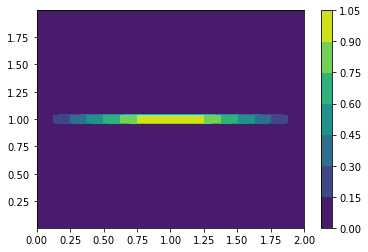

In [13]:
# Parameters
nx = 201
ny = 201
xmin = 0
xmax = 2
ymin = 0
ymax = 2

l2_target = 1e-8

# Spacing
dx = (xmax-xmin)/(nx-1)
dy = (ymax-ymin)/(ny-1)
dt = dx

# Mesh
x  = np.linspace(xmin,xmax,nx)
y  = np.linspace(ymin,ymax,ny)
X,Y = np.meshgrid(x,y)

m1X, m1Y = 0.5*(X[:-1] + X[1:]), 0.5*(Y[:-1] + Y[1:])
m2X, m2Y = 0.5*(X[:,:-1] + X[:,1:]), 0.5*(Y[:,:-1] + Y[:,1:])
pX, pY = 0.5*(X[:-1,:-1] + X[1:,1:]), 0.5*(Y[:-1,:-1] + Y[1:,1:])

# Source
#L = xmax-xmin
#b = -2*(pi/L)**2*np.sin(pi*X/L)*np.cos(pi*Y/L)

S = (pX<1)*np.ones((ny-1,nx-1)) - (pX>=1)*np.ones((ny-1,nx-1))
S = ((pX<1.2)*(pX>0.8)*(0.8<pY)*(pY<1.2) - (0.16/(4-0.16)))*np.ones((ny-1,nx-1))
#S = ((pX<0.7)*(pX>0.3)*(0.3<pY)*(pY<0.7) - (0.16/(4-0.16)))*np.ones((ny-1,nx-1))
#S = np.zeros(pX.shape)
# Initialization
S = S - np.sum(S)/((ny-1)*(nx-1))
#S = 0.3 * S
p = np.zeros((ny-1,nx-1))

m1 = ((m1X<=0.8)*(1.2*m1X) + 0.96*(m1X<1.2)*(m1X>0.8) + (m1X>=1.2)*(2.4-1.2*m1X))*(m1Y>0.96)*(m1Y<1.04)
m2 = ((m2Y<=0.8)*(1.2*m2Y) + 0.96*(m2Y<1.2)*(m2Y>0.8) + (m2Y>=1.2)*(2.4-1.2*m2Y))*(m2X>0.96)*(m2X<1.04)
#m1 = ((m1Y<=0.8)*(1.2*m1Y) + 0.96*(m1Y<1.2)*(m1Y>0.8) + (m1Y>=1.2)*(2.4-1.2*m1Y))*(m1X>0.2)*(m1X<0.3)
#m1 = np.sin(np.pi * m1X) * (m1Y>0.96)*(m1Y<1.04)
#m2 = np.zeros(m2X.shape)
#m1 = ((m1Y<=0.8)*(1.2*m1Y) + 0.96*(m1Y<1.2)*(m1Y>0.8) + (m1Y>=1.2)*(2.4-1.2*m1Y))*(m1X>0.2)*(m1X<0.3) - \
#     ((m1Y<=0.8)*(1.2*m1Y) + 0.96*(m1Y<1.2)*(m1Y>0.8) + (m1Y>=1.2)*(2.4-1.2*m1Y))*(m1X>1.7)*(m1X<1.8)

#m1 = ((m1X - 0.5)**2 + (m1Y - 0.5)**2 < 1/16) * np.ones(m1X.shape)

# Parameters
r = 0.1
c = 50
D = 0.001
rho = 1e-12
gamma = 0.75

pyplot.contourf(m1X,m1Y,m1)
pyplot.colorbar()
pyplot.savefig('m1.pdf')

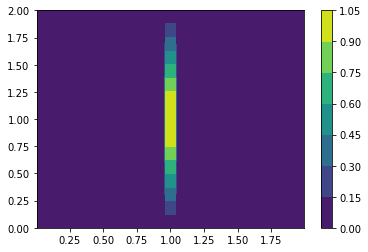

In [15]:
pyplot.contourf(m2X,m2Y,m2)
pyplot.colorbar()
pyplot.savefig('m2.pdf')

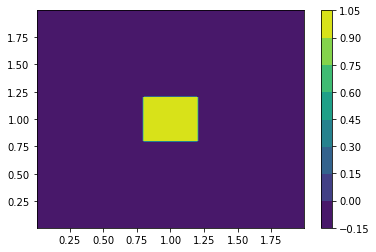

In [16]:
pyplot.contourf(pX,pY,S)
pyplot.colorbar()
pyplot.savefig('s.pdf')

In [17]:
nt = 500
for t in range(1,nt):
    p, conv0 = pcg_elliptic(p - np.sum(p)/((nx-1)*(ny-1)), m1, m2, r, elliptic, S, dx, dy, 0, l2_target)
    s1 = sx(p, m1, m2, dx, dy, dt, c, rho, gamma)
    s2 = sy(p, m1, m2, dx, dy, dt, c, rho, gamma)
    m1, conv1 = cg_diffusion_mx(m1, m1, m2, D, rho, gamma, diffusion_mx, s1, dx, dy, dt, l2_target)
    m2, conv2 = cg_diffusion_my(m2, m1, m2, D, rho, gamma, diffusion_my, s2, dx, dy, dt, l2_target)

Number of PCG iterations: 29
Number of CG iterations: 3
Number of CG iterations: 3
Number of PCG iterations: 61
Number of CG iterations: 3
Number of CG iterations: 3
Number of PCG iterations: 66
Number of CG iterations: 3
Number of CG iterations: 3
Number of PCG iterations: 68
Number of CG iterations: 3
Number of CG iterations: 3
Number of PCG iterations: 70
Number of CG iterations: 3
Number of CG iterations: 3
Number of PCG iterations: 75
Number of CG iterations: 3
Number of CG iterations: 3
Number of PCG iterations: 74
Number of CG iterations: 3
Number of CG iterations: 3
Number of PCG iterations: 73
Number of CG iterations: 3
Number of CG iterations: 3
Number of PCG iterations: 72
Number of CG iterations: 3
Number of CG iterations: 3
Number of PCG iterations: 78
Number of CG iterations: 3
Number of CG iterations: 3
Number of PCG iterations: 71
Number of CG iterations: 3
Number of CG iterations: 3
Number of PCG iterations: 75
Number of CG iterations: 3
Number of CG iterations: 3
Numb

In [56]:
nt = 500
for t in range(1,nt):
    p, conv0 = pcg_elliptic(p - np.sum(p)/((nx-1)*(ny-1)), m1, m2, r, elliptic, S, dx, dy, 0, l2_target)
    s1 = sx_im(p, m1, m2, dx, dy, dt, c, rho, gamma)
    s2 = sy_im(p, m1, m2, dx, dy, dt, c, rho, gamma)
    m1, conv1 = cg_diffusion_mx(m1, m1, m2, D, rho, gamma, diffusion_mx_im, s1, dx, dy, dt, l2_target)
    m2, conv2 = cg_diffusion_my(m2, m1, m2, D, rho, gamma, diffusion_my_im, s2, dx, dy, dt, l2_target)

Number of PCG iterations: 35
Number of CG iterations: 8
Number of CG iterations: 9
Number of PCG iterations: 35
Number of CG iterations: 9
Number of CG iterations: 11
Number of PCG iterations: 34
Number of CG iterations: 11
Number of CG iterations: 16
Number of PCG iterations: 34
Number of CG iterations: 15
Number of CG iterations: 26
Number of PCG iterations: 34
Number of CG iterations: 27
Number of CG iterations: 37
Number of PCG iterations: 34
Number of CG iterations: 38
Number of CG iterations: 55
Number of PCG iterations: 32
Number of CG iterations: 55
Number of CG iterations: 58
Number of PCG iterations: 32
Number of CG iterations: 67
Number of CG iterations: 45
Number of PCG iterations: 32
Number of CG iterations: 61
Number of CG iterations: 68
Number of PCG iterations: 32
Number of CG iterations: 54
Number of CG iterations: 64
Number of PCG iterations: 32
Number of CG iterations: 68
Number of CG iterations: 56
Number of PCG iterations: 32
Number of CG iterations: 59
Number of C

KeyboardInterrupt: 

In [70]:
uv = norm_u_test(p, m1, m2, r, dx, dy, dt)

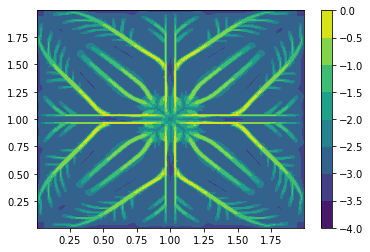

In [71]:
pyplot.contourf(pX,pY,np.log10(uv))
pyplot.colorbar()
pyplot.savefig('PCG.pdf')

In [ ]:
def diff_p(p, mx, my, r, dx, dy, dt):
    tmp_1, tmp_2 = np.zeros((mx.shape)), np.zeros((my.shape))
    tmp_1[:,1:-1] = ((my*diff_y(p,dy))[:-1,:-1] + (my*diff_y(p,dy))[1:,:-1] 
                     + (my*diff_y(p,dy))[:-1,1:] + (my*diff_y(p,dy))[1:,1:])/4
    tmp_2[1:-1] = ((mx*diff_x(p,dx))[:-1,:-1] + (mx*diff_x(p,dx))[1:,:-1] 
                   + (mx*diff_x(p,dx))[:-1,1:] + (mx*diff_x(p,dx))[1:,1:])/4
    u = r*diff_x(p,dx) + mx**2*diff_x(p,dx) + mx*tmp_1
    v = r*diff_y(p,dy) + my**2*diff_y(p,dy) + my*tmp_2
    return -u, -v

u, v = diff_p(p, m1, m2, r, dx, dy, dt)

u, v = 0.5*(u[:,:-1]+u[:,1:]), 0.5*(v[:-1]+v[1:])


fig0, ax0 = pyplot.subplots()
strm = ax0.streamplot(pX, pY, u, v, color=u, linewidth=2)
fig0.colorbar(strm.lines)

#fig1, (ax1, ax2) = pyplot.subplots(ncols=2)
#ax1.streamplot(X, Y, U, V, density=[0.5, 1])

#lw = 5*speed / speed.max()
#ax2.streamplot(X, Y, U, V, density=0.6, color='k', linewidth=lw)

pyplot.savefig('vector.pdf')

In [ ]:
from IPython.core.display import HTML
css_file = '../../styles/numericalmoocstyle.css'
HTML(open(css_file, "r").read())